In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
import glob
import pandas as pd
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u
import lmfit
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.stats import pearsonr
from scipy.stats import spearmanr
import emcee
import corner

plt.rcParams['text.usetex']= True
plt.rcParams['mathtext.fontset']= 'custom'
plt.rcParams['mathtext.default']= 'rm'
plt.rcParams['axes.formatter.use_mathtext']=False

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### Loading in data

In [3]:
sample_df = pd.read_csv('sample_Balmer_UV_mass.csv')
# removing source with too high of error on UV luminosity measurement
sample_df.drop(sample_df[sample_df['NIRSPEC ID'] == 2514].index, inplace=True)

print('max redshift:',max(sample_df['REDSHIFT']))
print('min redshift:',min(sample_df['REDSHIFT']))

max redshift: 6.612528
min redshift: 1.064851


### Binning and sorting dataframe by redshift

In [5]:
bins = ['1-2', '2-4','4-6.6']
sample_df['Z BIN'] = pd.cut(sample_df['REDSHIFT'], [1,2,4,6.7], labels=bins) # adding a columns at the end of the dataframe
sample_df.sort_values(by=['Z BIN'], inplace=True)
sample_df.head()

,NIRSPEC ID,REDSHIFT,RA,DEC,PHOTOMETRIC CATALOG,UV LUMINOSITY DENSITY REST-FRAME,UV LUMINOSITY DENSITY REST-FRAME ERROR,H-ALPHA INTEGRATED LUMINOSITY,H-ALPHA INTEGRATED LUMINOSITY MEAN ERROR,H-ALPHA INTEGRATED LUMINOSITY 16% ERROR,...,H-ALPHA INTEGRATED FLUX 16% ERROR,H-ALPHA INTEGRATED FLUX 84% ERROR,H-BETA INTEGRATED FLUX,H-BETA INTEGRATED FLUX MEAN ERROR,H-BETA INTEGRATED FLUX 16% ERROR,H-BETA INTEGRATED FLUX 84% ERROR,MASS MEDIAN,MASS 16% ERROR,MASS 84% ERROR,Z BIN
127,37597,1.416468,215.082111,52.998676,CANDLES F606W,1.025050e+43,1.571916e+42,1.756151e+41,3.628959e+38,7.160157e+39,...,5.500036e-19,5.032370e-19,5.417185e-18,1.292218e-20,3.752214e-19,3.755194e-19,6.698176,0.080704,0.137460,1-2
92,9413,1.389759,215.061204,53.003512,CANDLES F606W,8.066848e+43,3.322442e+42,1.191960e+41,1.114346e+38,6.653296e+39,...,5.355994e-19,5.374372e-19,2.967873e-18,3.245927e-20,6.593446e-19,7.225666e-19,9.665505,0.134320,0.103024,1-2
91,9238,1.741577,215.077787,53.006512,CANDLES F606W,9.545548e+43,4.470868e+42,5.061886e+41,3.041133e+38,1.118686e+40,...,5.171761e-19,5.261647e-19,5.804934e-18,9.437059e-20,1.021877e-18,1.012479e-18,7.737664,0.025036,0.041517,1-2
88,8971,1.573341,215.155246,53.048800,CANDLES F606W,2.915462e+44,3.734030e+42,9.247879e+41,2.897243e+38,1.825461e+40,...,1.082915e-18,1.054635e-18,1.390300e-17,1.937541e-20,6.345499e-19,6.181908e-19,8.956551,0.020618,0.020400,1-2
87,8736,1.554028,214.885556,52.835043,UNICORN F606W,9.629763e+43,3.131652e+42,2.018705e+41,2.758762e+38,9.848380e+39,...,6.022417e-19,5.933063e-19,4.095498e-18,1.039173e-20,4.696860e-19,4.603576e-19,8.094908,0.157097,0.171147,1-2


### Calculating SFR(H-alpha)

In [7]:
def SFR_lum(lum_Ha,lum_Ha_err):
    '''
    SFR indicator correction from Popesso et al. 2023 (eq. 4)
    returns SFR in units of [solar mass / yr]
    '''
    factor = 2.06e-8   # [solar lum]

    # converting H-alpha luminosity from [erg/s] to [solar luminosity]
    lum_Ha_solar = lum_Ha / (3.826e33)
    lum_Ha_err_solar = lum_Ha_err / (3.826e33)

    # calculating SFR [solar mass / yr]
    SFR = factor * lum_Ha_solar
    SFR_err = factor * lum_Ha_err_solar
    return SFR, SFR_err

In [8]:
SFRs, SFRs_err = SFR_lum(sample_df['H-ALPHA INTEGRATED LUMINOSITY'],sample_df['H-ALPHA INTEGRATED LUMINOSITY MEAN ERROR'])
sample_df.insert(7, 'H-ALPHA SFR', SFRs)            # adding column at the beginning of Balmer emission columns
sample_df.insert(8, 'H-ALPHA SFR ERROR', SFRs_err)  # ''

### Ha-to-UV luminosity ratio

In [10]:
UV_lum = sample_df['UV LUMINOSITY DENSITY REST-FRAME']
Ha_lum = sample_df['H-ALPHA INTEGRATED LUMINOSITY']
UV_lum_err = sample_df['UV LUMINOSITY DENSITY REST-FRAME ERROR']
Ha_lum_err = sample_df['H-ALPHA INTEGRATED LUMINOSITY MEAN ERROR']

# actual ratio
lum_ratio = Ha_lum / UV_lum
log_lum_ratio = np.log10(lum_ratio).tolist()

# error propagation
relative_error_UV = UV_lum_err / UV_lum
relative_error_Ha = Ha_lum_err / Ha_lum
    
# propagate error in ratio
lum_ratio_error = np.sqrt(relative_error_UV**2 + relative_error_Ha**2) * lum_ratio
# propagate error in logarithm
log_lum_ratio_error = ((lum_ratio_error / lum_ratio) * (1 / np.log(10))).tolist()
    
sample_df.insert(5, 'H-ALPHA-TO-UV LUMINOSITY RATIO', lum_ratio)   # adding column at the beginning of emission columns
sample_df.insert(6, 'H-ALPHA-TO-UV LUMINOSITY RATIO ERROR', lum_ratio_error) 
sample_df.insert(7, 'LOG H-ALPHA-TO-UV LUMINOSITY RATIO', log_lum_ratio) 
sample_df.insert(8, 'LOG H-ALPHA-TO-UV LUMINOSITY RATIO ERROR', log_lum_ratio_error) 

### Linear Regression of Star-Forming Main Sequence with MCMC

In [12]:
def linear_model(x, m, b):
    return m * x + b

def log_likelihood(theta, x, y, yerr):
    m, b, lnf = theta['m'], theta['b'], theta['lnf']
    model = linear_model(x, m, b)
    inv_sigma2 = 1.0 / (yerr**2 + model**2 * np.exp(2 * lnf))
    return -0.5 * (np.sum((y - model)**2 * inv_sigma2 - np.log(inv_sigma2)))

In [13]:
# a dictionary where the keys are the bin values and the values are the corresponding DataFrames
df_split_by_bins = {}

# Iterate over each unique value in 'Z BIN'
for bin_value in bins:
    # Filter the main DataFrame for each bin_value
    df_split_by_bins[bin_value] = sample_df[sample_df['Z BIN'] == bin_value]

Least-squares results:
        m = 0.08060045200772947 ± 7.888244538698677e-05 
        b = 41.082718858189764 ± 0.0006936268276956601 
    


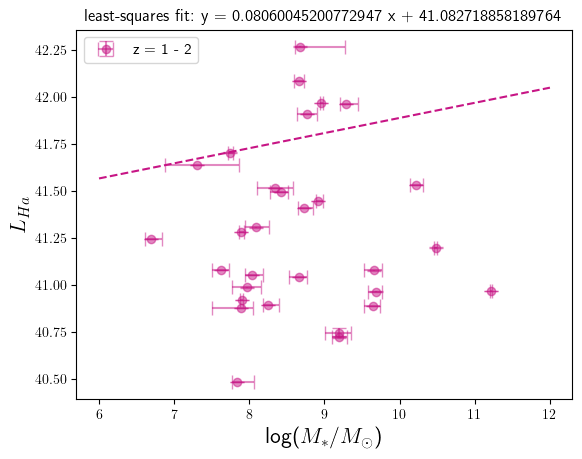

Maximum likelihood result:
        m = 8.327261102891725e-11 
        b = 41.28803616662077 
        f = 0.010647223534089556 
    


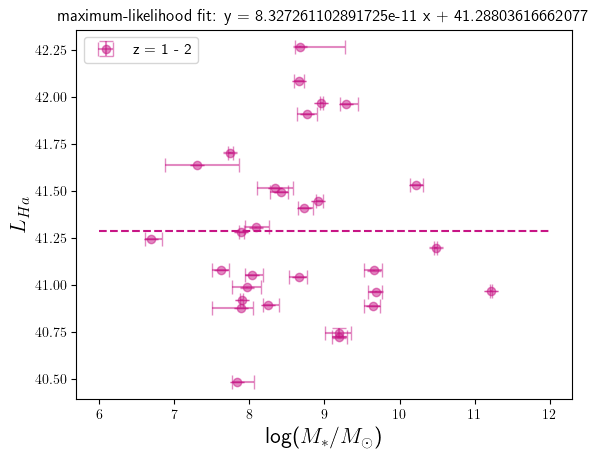

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:07<00:00, 44.13it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 60;
tau: [42.3905236  38.17957468 97.52864095]


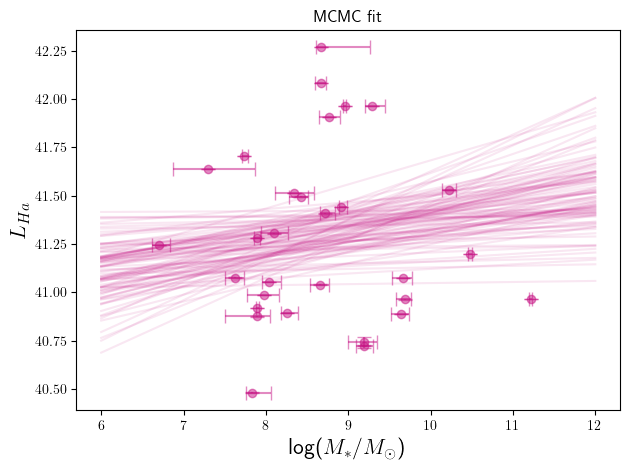

MCMC result:
        m = 0.05795971483336126 +0.058141341558926356 -0.03985112365237923 
        b = 40.796412636888 +0.3361818593049861 -0.5371574290696586 
        f = 0.011049665450186768 +0.0015646222918854896 -0.0013235193220779706 
    
Least-squares results:
        m = -0.03233388967191786 ± 5.410571436993956e-05 
        b = 42.381720539198795 ± 0.00048142372671428275 
    


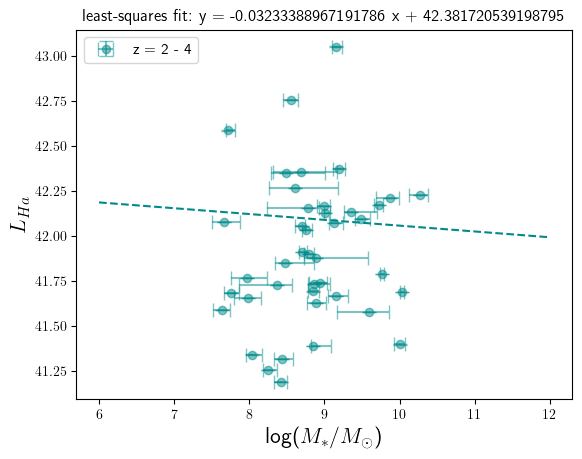

Maximum likelihood result:
        m = 0.0 
        b = 41.92048532644414 
        f = 0.009521762277849417 
    


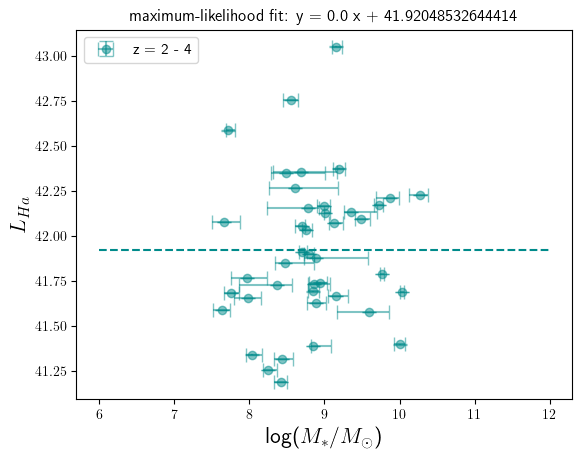

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:07<00:00, 44.35it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 60;
tau: [ 36.88821724  53.66689204 112.81013162]


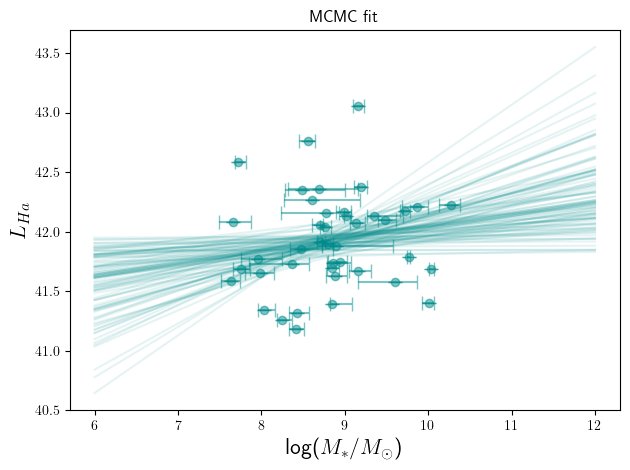

MCMC result:
        m = 0.10373934163153016 +0.0902330054422668 -0.06635064850586653 
        b = 40.99796211447983 +0.5904902263823644 -0.7923415368548916 
        f = 0.009721798530288485 +0.0012341214461972765 -0.0009305989452366038 
    
Least-squares results:
        m = 0.051199424659898796 ± 4.545233914712093e-05 
        b = 41.94940618603323 ± 0.0004189955834742849 
    


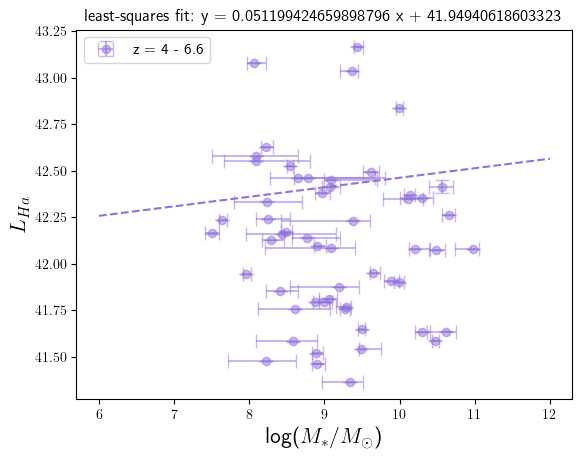

Maximum likelihood result:
        m = 3.0531133177191805e-14 
        b = 42.11875577478668 
        f = 0.009895041118250417 
    


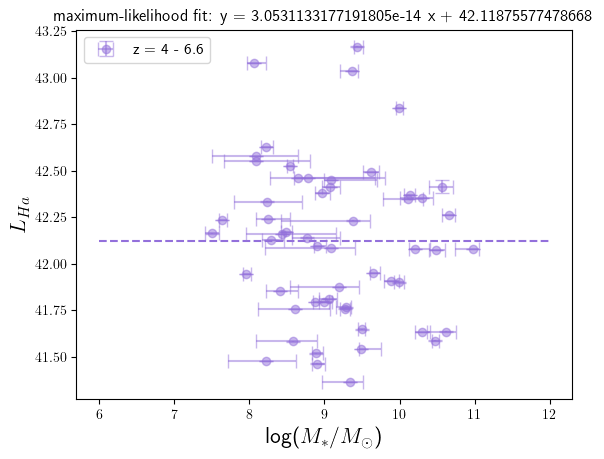

100%|██████████████████████████████████████████████████████████████████████████████| 3000/3000 [01:08<00:00, 44.06it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 60;
tau: [ 76.22638717  52.39653358 135.30418283]


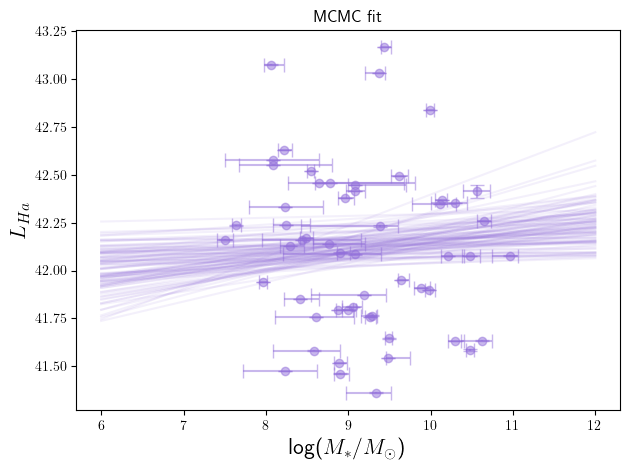

MCMC result:
        m = 0.03357638971754395 +0.04118081639650141 -0.02393301380014375 
        b = 41.809196153814185 +0.2311675888458069 -0.376224066055002 
        f = 0.0101685096498511 +0.0009917792790358534 -0.0009238129036597733 
    


In [14]:
# for diagnosis plotting
color_list = ['mediumvioletred','darkcyan','mediumpurple','peru']
label_list = ['z = 1 - 2','z = 2 - 4','z = 4 - 6.6']

m_emcee_list = []
b_emcee_list = []
residuals = []
residuals_err = []
for i, bin in enumerate(bins):

    # dataframe of current bin
    df = df_split_by_bins[bin]

    # data for current bin
    x_data = df['MASS MEDIAN']
    xtop = df['MASS 16% ERROR']
    xbot = df['MASS 84% ERROR']
    # symmetric error approximation
    x_data_err = (xtop + xbot) / 2.0

    # transform to log
    y_data = np.log10(df['H-ALPHA INTEGRATED LUMINOSITY'])
    y_data_err = df['H-ALPHA INTEGRATED LUMINOSITY MEAN ERROR'] / (df['H-ALPHA INTEGRATED LUMINOSITY'] * np.log(10))  # propogate error

    # LEAST SQUARES ------------------------------------------------
    A = np.vstack((np.ones_like(x_data), x_data)).T
    C = np.diag(y_data_err * y_data_err)
    cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
    b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y_data)))
    print("""Least-squares results:
        m = {0} ± {1} 
        b = {2} ± {3} 
    """.format(m_ls, np.sqrt(cov[1, 1]), b_ls, np.sqrt(cov[0, 0])))

    x_arr = np.linspace(6, 12, 100)
    plt.figure()
    plt.title(f'least-squares fit: y = {m_ls} x + {b_ls}')
    plt.ylabel(r'$L_{Ha}$',fontsize=16)
    plt.xlabel(r'log($M_*$/$M_{\odot}$)',fontsize=16)
    plt.errorbar(x_data, y_data, xerr=(xtop, xbot), yerr=y_data_err, color=color_list[i], alpha=0.5, fmt = 'o', markersize=6, capsize=5,label=label_list[i])
    plt.plot(x_arr, linear_model(x_arr, m_ls, b_ls), color=color_list[i], linestyle='--')
    plt.legend(prop={'size': 11},loc='upper left')
    plt.show()

    # MAXIMUM LIKELIHOOD --------------------------------------------------
    params = lmfit.Parameters()
    params.add(name='m', value=m_ls, vary=True, min=0, max=0.5)
    params.add(name='b', value=b_ls, vary=True, min=30, max=50)
    params.add(name='lnf', value=0.5, vary=True, min=-10, max=1.0)

    chi2 = lambda *args: -2 * log_likelihood(*args, x_data, y_data, y_data_err)
    # have to setup Minimizer with chi2, because lnlike is a probability
    mini = lmfit.Minimizer(chi2, params)
    res = mini.minimize('lbfgsb')
    m_ml, b_ml, lnf_ml = res.params['m'].value, res.params['b'].value, res.params['lnf'].value
    
    print("""Maximum likelihood result:
        m = {0} 
        b = {1} 
        f = {2} 
    """.format(m_ml, b_ml, np.exp(lnf_ml)))

    plt.figure()
    plt.title(f'maximum-likelihood fit: y = {m_ml} x + {b_ml}')
    plt.ylabel(r'$L_{Ha}$',fontsize=16)
    plt.xlabel(r'log($M_*$/$M_{\odot}$)',fontsize=16)
    plt.errorbar(x_data, y_data, xerr=(xtop, xbot), yerr=y_data_err, color=color_list[i], alpha=0.5, fmt = 'o', markersize=6, capsize=5,label=label_list[i])
    plt.plot(x_arr, linear_model(x_arr, m_ml, b_ml), color=color_list[i], linestyle='--')
    plt.legend(prop={'size': 11},loc='upper left')
    plt.show()

    # EMCEE ------------------------------------------------------- 
    ndim = len(params)  # Number of parameters
    nwalkers = 20  # Number of walkers
    p0 = []
    for _ in range(nwalkers):
        p0.append([params[name].value + 1e-4 * np.random.randn() for name in params])
    
    res2 = lmfit.minimize(
    log_likelihood,
    args=(x_data, y_data, y_data_err),
    params=res.params,
    method='emcee',
    pos=p0,
    steps=3000,
    nwalkers=nwalkers,  
    burn=2000,
    thin=15, 
    is_weighted=False,
    seed=42
    )

    samples = res2.chain.reshape((-1, 3))

    '''
    # diagnostic plots
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8, 9))
    axes[0].plot(res2.chain[:, :, 0].T, color="k", alpha=0.4)
    axes[0].set_ylabel("$m$")
    
    axes[1].plot(res2.chain[:, :, 1].T, color="k", alpha=0.4)
    axes[1].set_ylabel("$b$")
    
    axes[2].plot(np.exp(res2.chain[:, :, 2]).T, color="k", alpha=0.4)
    axes[2].set_ylabel("$f$")
    axes[2].set_xlabel("step number")
    
    fig.tight_layout(h_pad=0.0)

    fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"])
    '''

    plt.figure()
    plt.title('MCMC fit')
    for m, b, lnf in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(x_arr, linear_model(x_arr, m, b), color=color_list[i], alpha=0.1)
    plt.errorbar(x_data, y_data, xerr=(xtop, xbot), yerr=y_data_err, color=color_list[i], alpha=0.5, fmt = 'o', markersize=6, capsize=5,label=label_list[i])
    plt.ylabel(r'$L_{Ha}$',fontsize=16)
    plt.xlabel(r'log($M_*$/$M_{\odot}$)',fontsize=16)
    plt.tight_layout()
    plt.show()

    # compute quantiles
    samples[:, 2] = np.exp(samples[:, 2])
    m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                 zip(*np.percentile(samples, [16, 50, 84],
                                                    axis=0)))
    print("""MCMC result:
        m = {0[0]} +{0[1]} -{0[2]} 
        b = {1[0]} +{1[1]} -{1[2]} 
        f = {2[0]} +{2[1]} -{2[2]} 
    """.format(m_mcmc, b_mcmc, f_mcmc))

    # compute residuals
    y_model = linear_model(x_data, m_mcmc[0], b_mcmc[0])
    res = y_data - y_model

    y_model_samples = np.array([linear_model(x_data, m, b) for m, b, lnf in samples])
    model_uncertainty = np.std(y_model_samples, axis=0)
    res_err = np.sqrt(y_data_err**2 + model_uncertainty**2)
    
    '''
    model_upper_bound = linear_model(x_data, m_mcmc[1], b_mcmc[1])
    model_lower_bound = linear_model(x_data, m_mcmc[2], b_mcmc[2])
    res_err_upper = np.abs(y_data - model_upper_bound)
    res_err_lower = np.abs(y_data - model_lower_bound)
    res_err = np.mean([res_err_lower,res_err_upper])
    '''
    
    m_emcee_list.append(m_mcmc[0])
    b_emcee_list.append(b_mcmc[0])
    residuals.append(res)
    residuals_err.append(res_err)

In [15]:
# adding results to main dataframe
m_sfms = []
b_sfms = []
residuals_col = []
residuals_err_col = []
for i, bin in enumerate(bins):
    residuals_col.extend(residuals[i])
    residuals_err_col.extend(residuals_err[i])

    m_sfms.extend([m_emcee_list[i]] * len(df_split_by_bins[bin]))
    b_sfms.extend([b_emcee_list[i]] * len(df_split_by_bins[bin]))

sample_df['RESIDUALS'] = residuals_col
sample_df['RESIDUALS ERROR'] = residuals_err_col
sample_df['SFMS SLOPE'] = m_sfms
sample_df['SFMS INTERCEPT'] = b_sfms
sample_df.head()

,NIRSPEC ID,REDSHIFT,RA,DEC,PHOTOMETRIC CATALOG,H-ALPHA-TO-UV LUMINOSITY RATIO,H-ALPHA-TO-UV LUMINOSITY RATIO ERROR,LOG H-ALPHA-TO-UV LUMINOSITY RATIO,LOG H-ALPHA-TO-UV LUMINOSITY RATIO ERROR,UV LUMINOSITY DENSITY REST-FRAME,...,H-BETA INTEGRATED FLUX 16% ERROR,H-BETA INTEGRATED FLUX 84% ERROR,MASS MEDIAN,MASS 16% ERROR,MASS 84% ERROR,Z BIN,RESIDUALS,RESIDUALS ERROR,SFMS SLOPE,SFMS INTERCEPT
127,37597,1.416468,215.082111,52.998676,CANDLES F606W,0.017132,0.002627,-1.766183,0.066605,1.025050e+43,...,3.752214e-19,3.755194e-19,6.698176,0.080704,0.137460,1-2,0.059925,0.136854,0.05796,40.796413
92,9413,1.389759,215.061204,53.003512,CANDLES F606W,0.001478,0.000061,-2.830442,0.017892,8.066848e+43,...,6.593446e-19,7.225666e-19,9.665505,0.134320,0.103024,1-2,-0.280361,0.107369,0.05796,40.796413
91,9238,1.741577,215.077787,53.006512,CANDLES F606W,0.005303,0.000248,-2.275488,0.020343,9.545548e+43,...,1.021877e-18,1.012479e-18,7.737664,0.025036,0.041517,1-2,0.459427,0.103479,0.05796,40.796413
88,8971,1.573341,215.155246,53.048800,CANDLES F606W,0.003172,0.000041,-2.498665,0.005564,2.915462e+44,...,6.345499e-19,6.181908e-19,8.956551,0.020618,0.020400,1-2,0.650510,0.094103,0.05796,40.796413
87,8736,1.554028,214.885556,52.835043,UNICORN F606W,0.002096,0.000068,-2.678543,0.014136,9.629763e+43,...,4.696860e-19,4.603576e-19,8.094908,0.157097,0.171147,1-2,0.039482,0.096543,0.05796,40.796413


In [16]:
# a dictionary where the keys are the bin values and the values are the corresponding DataFrames
df_split_by_bins = {}

# Iterate over each unique value in 'Z BIN'
for bin_value in bins:
    # Filter the main DataFrame for each bin_value
    df_split_by_bins[bin_value] = sample_df[sample_df['Z BIN'] == bin_value]

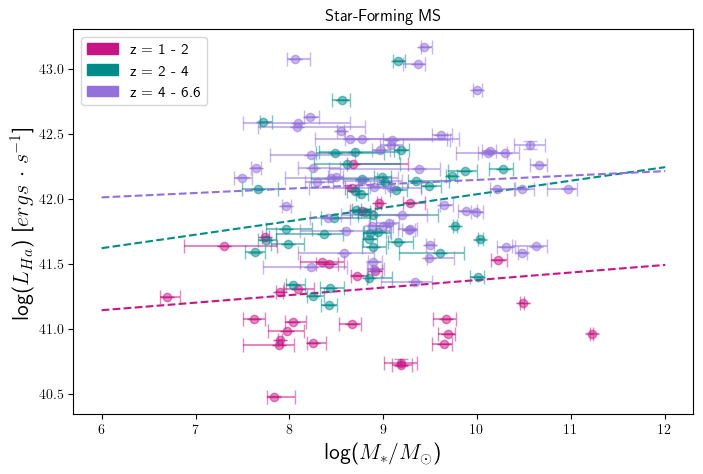

In [18]:
plt.figure(figsize=(8,5))
for i, bin in enumerate(bins):

    # dataframe of current bin
    df = df_split_by_bins[bin]

    # data for current redshift bin
    xtop = df['MASS 16% ERROR']
    xbot = df['MASS 84% ERROR']
    x_data = df['MASS MEDIAN']
    
    # transform to log
    y_data = np.log10(df['H-ALPHA INTEGRATED LUMINOSITY'])
    y_data_err = df['H-ALPHA INTEGRATED LUMINOSITY MEAN ERROR'] / (df['H-ALPHA INTEGRATED LUMINOSITY'] * np.log(10))  # propogate error

    # regression line
    x_arr = np.linspace(6, 12, 100).reshape((-1, 1))
    y_arr = linear_model(x_arr, df['SFMS SLOPE'].iloc[0], df['SFMS INTERCEPT'].iloc[0]) 

    # plotting
    plt.errorbar(x_data, y_data, xerr=(xtop, xbot), yerr=y_data_err, color=color_list[i], alpha=0.5, fmt = 'o', markersize=6, capsize=5)
    plt.plot(x_arr, y_arr, color=color_list[i], linestyle='--')

plt.title('Star-Forming MS')
plt.xlabel(r'log($M_*$/$M_{\odot}$)',fontsize=16)
plt.ylabel(r'log($L_{Ha}$) [$ergs$ $\cdot$ $s^{-1}$]',fontsize=16)

# access legend objects automatically created from data
handles, labels = plt.gca().get_legend_handles_labels()
patch1 = mpatches.Patch(color=color_list[0], label=label_list[0])   
patch2 = mpatches.Patch(color=color_list[1], label=label_list[1]) 
patch3 = mpatches.Patch(color=color_list[2], label=label_list[2]) 
#patch4 = mpatches.Patch(color=color_list[3], label=label_list[3]) 
handles.extend([patch1, patch2, patch3])
plt.legend(handles=handles,prop={'size': 11},loc='upper left')
#plt.yscale('log')
plt.show()

### Dex cutoff for luminosity ratio

In [27]:
# a dictionary where the keys are the bin values and the values are the corresponding DataFrames
df_split_by_bins = {}

# Iterate over each unique value in 'Z BIN'
for bin_value in bins:
    # Filter the main DataFrame for each bin_value
    df_split_by_bins[bin_value] = sample_df[sample_df['Z BIN'] == bin_value]

In [28]:
flags = []
x_data = [[] for i in range(len(bins))]
x_data_err = [[] for i in range(len(bins))]
y_data = [[] for i in range(len(bins))]
y_data_err = [[] for i in range(len(bins))]
x_data_cut =[[] for i in range(len(bins))]
x_data_err_cut = [[] for i in range(len(bins))]
y_data_cut = [[] for i in range(len(bins))]
y_data_err_cut = [[] for i in range(len(bins))]
for i, bin in enumerate(bins):

    # dataframe of current bin
    df = df_split_by_bins[bin]
    
    lum_ratio = df['H-ALPHA-TO-UV LUMINOSITY RATIO'].tolist()
    lum_ratio_err = df['H-ALPHA-TO-UV LUMINOSITY RATIO ERROR'].tolist()
    log_lum_ratio = df['LOG H-ALPHA-TO-UV LUMINOSITY RATIO'].tolist()
    log_lum_ratio_err = df['LOG H-ALPHA-TO-UV LUMINOSITY RATIO ERROR'].tolist()
    res = df['RESIDUALS'].tolist()
    res_err = df['RESIDUALS ERROR'].tolist()

    # source cut for high lum ratio 
    dex_list = ((np.array(lum_ratio_err) / np.array(lum_ratio)) * (1 / np.log(10))).tolist()
    for j, dex in enumerate(dex_list):
        if dex >= 0.13:
            flags.append(True)
            x_data_cut[i].append(res[j])
            x_data_err_cut[i].append(res_err[j])
            y_data_cut[i].append(log_lum_ratio[j])
            y_data_err_cut[i].append(log_lum_ratio_error[j])
        else:
            flags.append(False)
            x_data[i].append(res[j])
            x_data_err[i].append(res_err[j])
            y_data[i].append(log_lum_ratio[j])
            y_data_err[i].append(log_lum_ratio_error[j])

    # convert to array for mathematical manipulation later
    x_data[i] = np.array(x_data[i])
    x_data_err[i] = np.array(x_data_err[i])
    y_data[i] = np.array(y_data[i])
    y_data_err[i] = np.array(y_data_err[i])
    x_data_cut[i] = np.array(x_data_cut[i])
    x_data_err_cut[i] = np.array(x_data_err_cut[i])
    y_data_cut[i] = np.array(y_data_cut[i])
    y_data_err_cut[i] = np.array(y_data_err_cut[i])

sample_df['FLAG'] = flags

In [29]:
# a dictionary where the keys are the bin values and the values are the corresponding DataFrames
df_split_by_bins = {}

# Iterate over each unique value in 'Z BIN'
for bin_value in bins:
    # Filter the main DataFrame for each bin_value
    df_split_by_bins[bin_value] = sample_df[sample_df['Z BIN'] == bin_value]

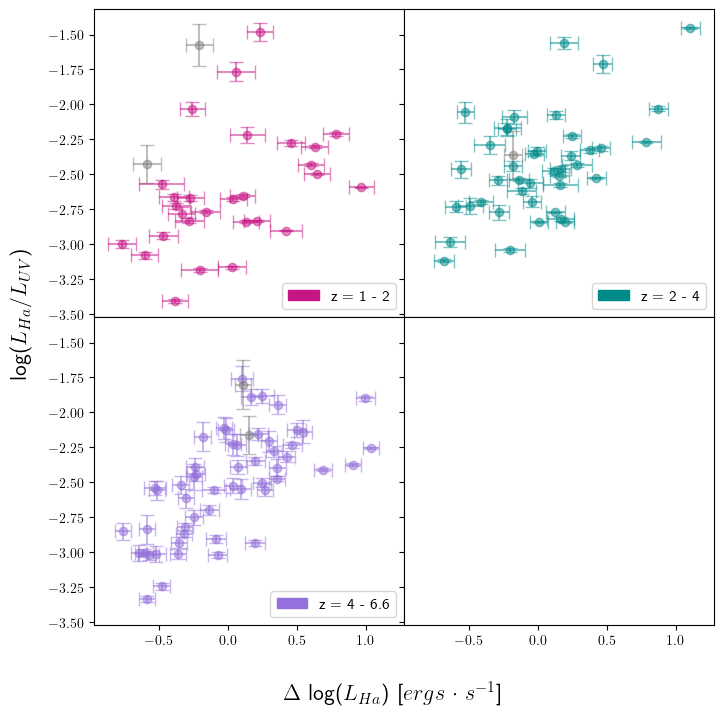

In [30]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
fig.supxlabel(r'$\Delta$ log($L_{Ha}$) [$ergs$ $\cdot$ $s^{-1}$]', fontsize=16)
fig.supylabel(r'log($L_{Ha}$/$L_{UV}$)', fontsize=16)

for i, bin in enumerate(bins):
    ax = axs[i//2, i%2]
    
    # dataframe of current bin
    df = df_split_by_bins[bin]

    # looping through each source
    for source in range(len(df)):
    
        log_lum_ratio = df['LOG H-ALPHA-TO-UV LUMINOSITY RATIO'].iloc[source]
        log_lum_ratio_err = df['LOG H-ALPHA-TO-UV LUMINOSITY RATIO ERROR'].iloc[source]
        res = df['RESIDUALS'].iloc[source]
        res_err = df['RESIDUALS ERROR'].iloc[source]
    
        if df['FLAG'].iloc[source] == True:
            ax.errorbar(res, log_lum_ratio, xerr=res_err, yerr=log_lum_ratio_err, color='grey', alpha=0.5, fmt='o', markersize=6, capsize=5)
        
        else:
            ax.errorbar(res, log_lum_ratio, xerr=res_err, yerr=log_lum_ratio_err, color=color_list[i], alpha=0.5, fmt='o', markersize=6, capsize=5, label=label_list[i])

    # access legend objects automatically created from data
    handles, labels = plt.gca().get_legend_handles_labels()
    patch = mpatches.Patch(color=color_list[i], label=label_list[i])   
    handles.extend([patch])
    ax.legend(handles=handles,prop={'size': 11},loc='lower right')

plt.subplots_adjust(wspace=0, hspace=0)  
plt.show()

### Linear Regression of Lum Ratio to Residuals

In [32]:
def linear_model(x, m, b):
    return m * x + b

def log_likelihood(theta, x, y, yerr):
    m, b, lnf = theta['m'], theta['b'], theta['lnf']
    model = linear_model(x, m, b)
    inv_sigma2 = 1.0 / (yerr**2 + model**2 * np.exp(2 * lnf))
    return -0.5 * (np.sum((y - model)**2 * inv_sigma2 - np.log(inv_sigma2)))

In [33]:
# a dictionary where the keys are the bin values and the values are the corresponding DataFrames
df_split_by_bins = {}

# Iterate over each unique value in 'Z BIN'
for bin_value in bins:
    # Filter the main DataFrame for each bin_value
    df_split_by_bins[bin_value] = sample_df[sample_df['Z BIN'] == bin_value]

Least-squares results:
        m = 0.3516886624858593 ± 0.004877589033172369 
        b = -2.8966629876246093 ± 0.002794547619165078 
    


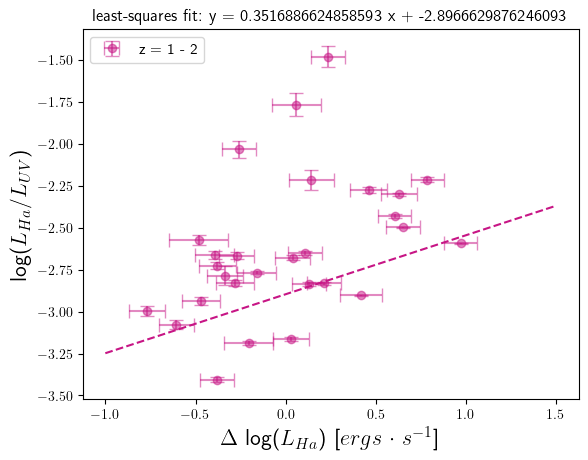

Maximum likelihood result:
        m = 0.37085725369731676 
        b = -2.6334579214943226 
        f = 0.14374101344321918 
    


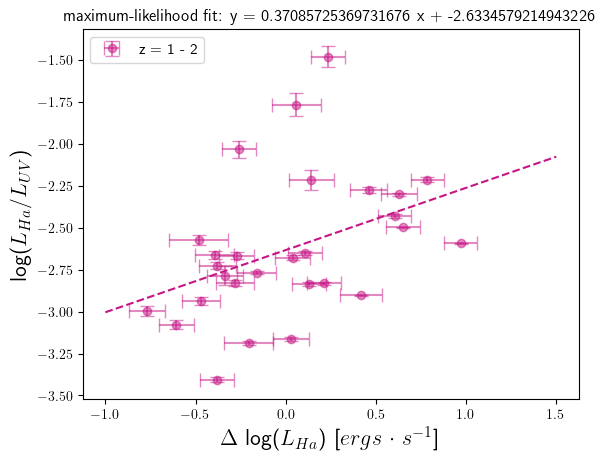

100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:08<00:00, 337.65it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 60;
tau: [35.47863165 28.97578091 73.2751362 ]


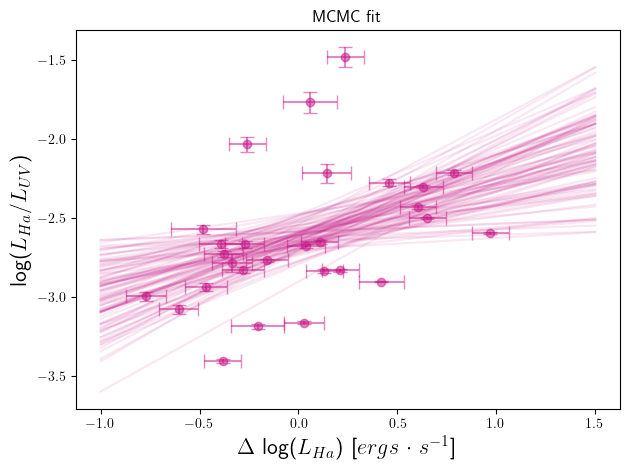

MCMC result:
        m = 0.3576461109173712 +0.1490838216439624 -0.15517379796185618 
        b = -2.633747888807779 +0.07390066762397085 -0.07118391939579816 
        f = 0.15138879023116258 +0.024187527717619006 -0.01899347823751968 
    
Least-squares results:
        m = 0.5313454694916333 ± 0.0033644163490178115 
        b = -2.2684545660001985 ± 0.0016971720374355005 
    


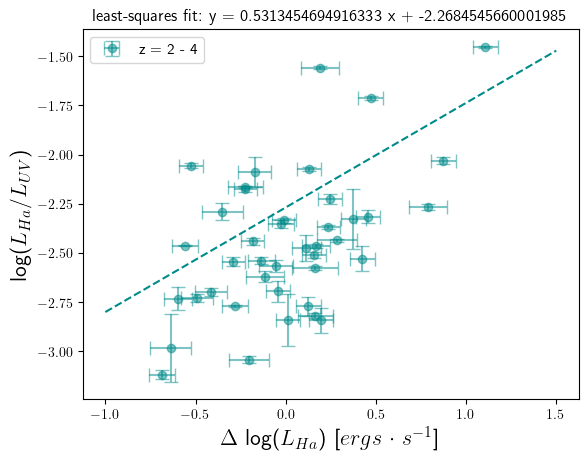

Maximum likelihood result:
        m = 0.49756892515305656 
        b = -2.4404480640219965 
        f = 0.12656904424813947 
    


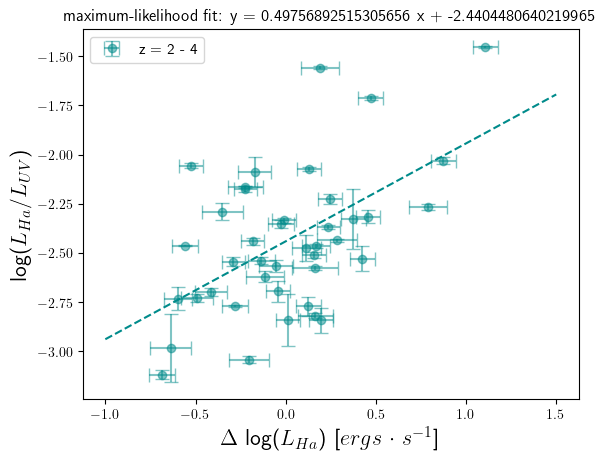

100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:09<00:00, 330.16it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 60;
tau: [44.11274248 44.28111444 80.00423622]


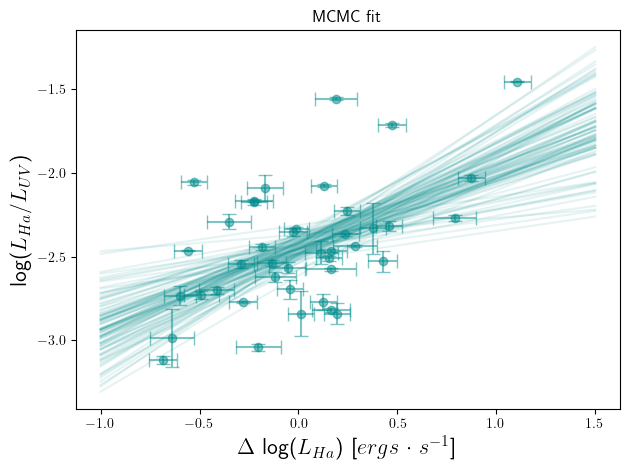

MCMC result:
        m = 0.49524498118981053 +0.1257015903955725 -0.12465200909436208 
        b = -2.4455126871470547 +0.05576144227074087 -0.05434515404462337 
        f = 0.13121326163125127 +0.016078733456292432 -0.014070010163691332 
    
Least-squares results:
        m = 0.9224628701576896 ± 0.005055841339575544 
        b = -2.3700828770394513 ± 0.0015513269587584038 
    


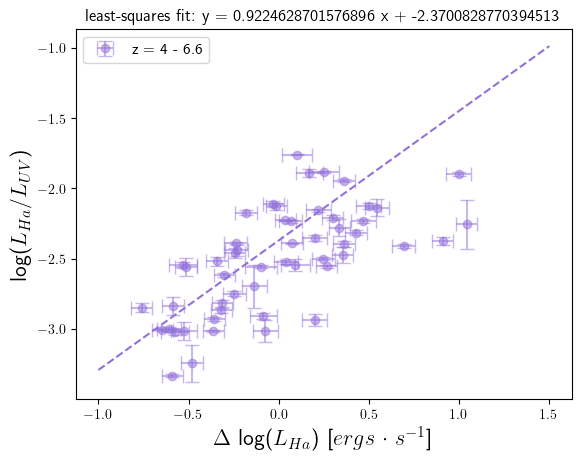

Maximum likelihood result:
        m = 0.5312979481382294 
        b = -2.4976970854782294 
        f = 0.10970311056879416 
    


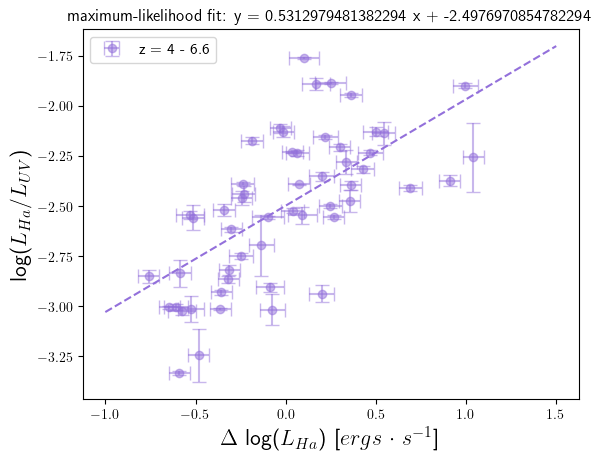

100%|█████████████████████████████████████████████████████████████████████████████| 3000/3000 [00:08<00:00, 335.18it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 1 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 60;
tau: [41.39379769 47.19531051 79.78410369]


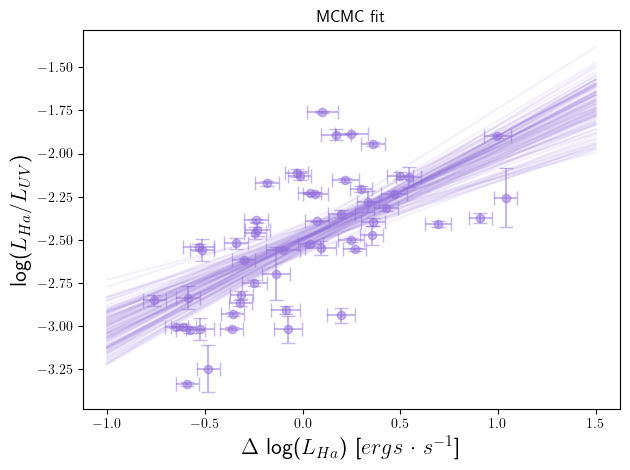

MCMC result:
        m = 0.5325883785681851 +0.07867769242535272 -0.08171879288469774 
        b = -2.498930782016538 +0.037667795720854436 -0.04073771397096504 
        f = 0.11292333607221085 +0.012810678967024522 -0.010742817472494476 
    


In [34]:
color_list = ['mediumvioletred','darkcyan','mediumpurple','peru']
label_list = ['z = 1 - 2','z = 2 - 4','z = 4 - 6.6']

m_emcee_list = []
b_emcee_list = []
for i, bin in enumerate(bins):

    # LEAST SQUARES ------------------------------------------------
    A = np.vstack((np.ones_like(x_data[i]), x_data[i])).T
    C = np.diag(y_data_err[i] * y_data_err[i])
    cov = np.linalg.inv(np.dot(A.T, np.linalg.solve(C, A)))
    b_ls, m_ls = np.dot(cov, np.dot(A.T, np.linalg.solve(C, y_data[i])))
    print("""Least-squares results:
        m = {0} ± {1} 
        b = {2} ± {3} 
    """.format(m_ls, np.sqrt(cov[1, 1]), b_ls, np.sqrt(cov[0, 0])))

    x_arr = np.linspace(-1, 1.5, 100)
    plt.figure()
    plt.title(f'least-squares fit: y = {m_ls} x + {b_ls}')
    plt.ylabel(r'log($L_{Ha}$/$L_{UV}$)',fontsize=16)
    plt.xlabel(r'$\Delta$ log($L_{Ha}$) [$ergs$ $\cdot$ $s^{-1}$]',fontsize=16)
    plt.errorbar(x_data[i], y_data[i], xerr=x_data_err[i], yerr=y_data_err[i], color=color_list[i], alpha=0.5, fmt = 'o', markersize=6, capsize=5,label=label_list[i])
    plt.plot(x_arr, linear_model(x_arr, m_ls, b_ls), color=color_list[i], linestyle='--')
    plt.legend(prop={'size': 11},loc='upper left')
    plt.show()

    # MAXIMUM LIKELIHOOD --------------------------------------------------
    params = lmfit.Parameters()
    params.add(name='m', value=m_ls, vary=True, min=0, max=5)
    params.add(name='b', value=b_ls, vary=True, min=-20, max=0)
    params.add(name='lnf', value=0.5, vary=True, min=-10, max=1.0)

    chi2 = lambda *args: -2 * log_likelihood(*args, x_data[i], y_data[i], y_data_err[i])
    # have to setup Minimizer with chi2, because lnlike is a probability
    mini = lmfit.Minimizer(chi2, params)
    res = mini.minimize('lbfgsb')
    m_ml, b_ml, lnf_ml = res.params['m'].value, res.params['b'].value, res.params['lnf'].value
    
    print("""Maximum likelihood result:
        m = {0} 
        b = {1} 
        f = {2} 
    """.format(m_ml, b_ml, np.exp(lnf_ml)))

    plt.figure()
    plt.title(f'maximum-likelihood fit: y = {m_ml} x + {b_ml}')
    plt.ylabel(r'log($L_{Ha}$/$L_{UV}$)',fontsize=16)
    plt.xlabel(r'$\Delta$ log($L_{Ha}$) [$ergs$ $\cdot$ $s^{-1}$]',fontsize=16)
    plt.errorbar(x_data[i], y_data[i], xerr=x_data_err[i], yerr=y_data_err[i], color=color_list[i], alpha=0.5, fmt = 'o', markersize=6, capsize=5,label=label_list[i])
    plt.plot(x_arr, linear_model(x_arr, m_ml, b_ml), color=color_list[i], linestyle='--')
    plt.legend(prop={'size': 11},loc='upper left')
    plt.show()

    # EMCEE ------------------------------------------------------- 
    ndim = len(params)  # Number of parameters
    nwalkers = 20  # Number of walkers
    p0 = []
    for _ in range(nwalkers):
        p0.append([params[name].value + 1e-4 * np.random.randn() for name in params])
    
    res2 = lmfit.minimize(
    log_likelihood,
    args=(x_data[i], y_data[i], y_data_err[i]),
    params=res.params,
    method='emcee',
    pos=p0,
    steps=3000,
    nwalkers=nwalkers,  
    burn=2000,
    thin=15, 
    is_weighted=False,
    seed=42
    )

    samples = res2.chain.reshape((-1, 3))

    '''
    # diagnostic plots
    fig, axes = plt.subplots(3, 1, sharex=True, figsize=(8, 9))
    axes[0].plot(res2.chain[:, :, 0].T, color="k", alpha=0.4)
    axes[0].set_ylabel("$m$")
    
    axes[1].plot(res2.chain[:, :, 1].T, color="k", alpha=0.4)
    axes[1].set_ylabel("$b$")
    
    axes[2].plot(np.exp(res2.chain[:, :, 2]).T, color="k", alpha=0.4)
    axes[2].set_ylabel("$f$")
    axes[2].set_xlabel("step number")
    
    fig.tight_layout(h_pad=0.0)

    fig = corner.corner(samples, labels=["$m$", "$b$", "$\ln\,f$"])
    '''

    plt.figure()
    plt.title('MCMC fit')
    for m, b, lnf in samples[np.random.randint(len(samples), size=100)]:
        plt.plot(x_arr, linear_model(x_arr, m, b), color=color_list[i], alpha=0.1)
    plt.errorbar(x_data[i], y_data[i], xerr=x_data_err[i], yerr=y_data_err[i], color=color_list[i], alpha=0.5, fmt = 'o', markersize=6, capsize=5,label=label_list[i])
    plt.ylabel(r'log($L_{Ha}$/$L_{UV}$)',fontsize=16)
    plt.xlabel(r'$\Delta$ log($L_{Ha}$) [$ergs$ $\cdot$ $s^{-1}$]',fontsize=16)
    plt.tight_layout()
    plt.show()

    # compute quantiles
    samples[:, 2] = np.exp(samples[:, 2])
    m_mcmc, b_mcmc, f_mcmc = map(lambda v: (v[1], v[2]-v[1], v[1]-v[0]),
                                 zip(*np.percentile(samples, [16, 50, 84],
                                                    axis=0)))
    print("""MCMC result:
        m = {0[0]} +{0[1]} -{0[2]} 
        b = {1[0]} +{1[1]} -{1[2]} 
        f = {2[0]} +{2[1]} -{2[2]} 
    """.format(m_mcmc, b_mcmc, f_mcmc))
    
    m_emcee_list.append(m_mcmc[0])
    b_emcee_list.append(b_mcmc[0])

In [35]:
# adding results to main dataframe
m_bursty = []
b_bursty = []
for i, bin in enumerate(bins):
    m_bursty.extend([m_emcee_list[i]] * len(df_split_by_bins[bin]))
    b_bursty.extend([b_emcee_list[i]] * len(df_split_by_bins[bin]))

sample_df['LUMINOSITY RATIO VS RESIDUAL SLOPE'] = m_bursty
sample_df['LUMINOSITY RATIO VS RESIDUAL INTERCEPT'] = b_bursty
sample_df.head()

,NIRSPEC ID,REDSHIFT,RA,DEC,PHOTOMETRIC CATALOG,H-ALPHA-TO-UV LUMINOSITY RATIO,H-ALPHA-TO-UV LUMINOSITY RATIO ERROR,LOG H-ALPHA-TO-UV LUMINOSITY RATIO,LOG H-ALPHA-TO-UV LUMINOSITY RATIO ERROR,UV LUMINOSITY DENSITY REST-FRAME,...,MASS 16% ERROR,MASS 84% ERROR,Z BIN,RESIDUALS,RESIDUALS ERROR,SFMS SLOPE,SFMS INTERCEPT,FLAG,LUMINOSITY RATIO VS RESIDUAL SLOPE,LUMINOSITY RATIO VS RESIDUAL INTERCEPT
127,37597,1.416468,215.082111,52.998676,CANDLES F606W,0.017132,0.002627,-1.766183,0.066605,1.025050e+43,...,0.080704,0.137460,1-2,0.059925,0.136854,0.05796,40.796413,False,0.357646,-2.633748
92,9413,1.389759,215.061204,53.003512,CANDLES F606W,0.001478,0.000061,-2.830442,0.017892,8.066848e+43,...,0.134320,0.103024,1-2,-0.280361,0.107369,0.05796,40.796413,False,0.357646,-2.633748
91,9238,1.741577,215.077787,53.006512,CANDLES F606W,0.005303,0.000248,-2.275488,0.020343,9.545548e+43,...,0.025036,0.041517,1-2,0.459427,0.103479,0.05796,40.796413,False,0.357646,-2.633748
88,8971,1.573341,215.155246,53.048800,CANDLES F606W,0.003172,0.000041,-2.498665,0.005564,2.915462e+44,...,0.020618,0.020400,1-2,0.650510,0.094103,0.05796,40.796413,False,0.357646,-2.633748
87,8736,1.554028,214.885556,52.835043,UNICORN F606W,0.002096,0.000068,-2.678543,0.014136,9.629763e+43,...,0.157097,0.171147,1-2,0.039482,0.096543,0.05796,40.796413,False,0.357646,-2.633748


In [36]:
# a dictionary where the keys are the bin values and the values are the corresponding DataFrames
df_split_by_bins = {}

# Iterate over each unique value in 'Z BIN'
for bin_value in bins:
    # Filter the main DataFrame for each bin_value
    df_split_by_bins[bin_value] = sample_df[sample_df['Z BIN'] == bin_value]

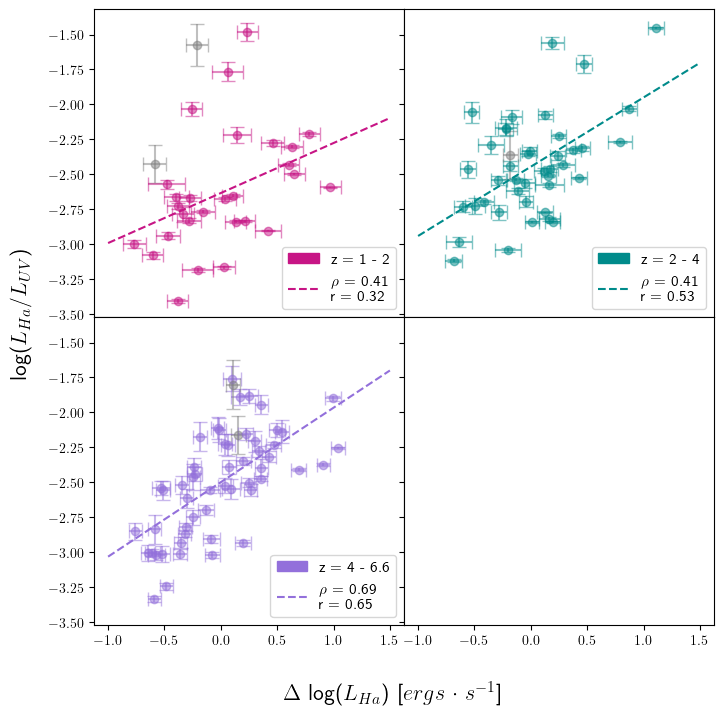

In [70]:
fig, axs = plt.subplots(2, 2, figsize=(8, 8), sharex=True, sharey=True)
fig.supxlabel(r'$\Delta$ log($L_{Ha}$) [$ergs$ $\cdot$ $s^{-1}$]', fontsize=16)
fig.supylabel(r'log($L_{Ha}$/$L_{UV}$)', fontsize=16)

for i, bin in enumerate(bins):
    ax = axs[i//2, i%2]
    
    # dataframe of current bin
    df = df_split_by_bins[bin]

    # Calculate Pearson's correlation coefficient
    y_data = df['LOG H-ALPHA-TO-UV LUMINOSITY RATIO'].tolist()
    x_data = df['RESIDUALS'].tolist()
    spearman_corr, p_val = spearmanr(x_data, y_data)
    pearson_corr, p_value = pearsonr(x_data, y_data)

    # regression line
    x_arr = np.linspace(-1, 1.5, 100).reshape((-1, 1))
    y_arr = linear_model(x_arr, df['LUMINOSITY RATIO VS RESIDUAL SLOPE'].iloc[0], df['LUMINOSITY RATIO VS RESIDUAL INTERCEPT'].iloc[0])
    ax.plot(x_arr, y_arr, color=color_list[i], linestyle='--')

    # looping through each source
    for source in range(len(df)):
    
        log_lum_ratio = df['LOG H-ALPHA-TO-UV LUMINOSITY RATIO'].iloc[source]
        log_lum_ratio_err = df['LOG H-ALPHA-TO-UV LUMINOSITY RATIO ERROR'].iloc[source]
        res = df['RESIDUALS'].iloc[source]
        res_err = df['RESIDUALS ERROR'].iloc[source]
    
        if df['FLAG'].iloc[source] == True:
            ax.errorbar(res, log_lum_ratio, xerr=res_err, yerr=log_lum_ratio_err, color='grey', alpha=0.5, fmt='o', markersize=6, capsize=5)
        
        else:
            ax.errorbar(res, log_lum_ratio, xerr=res_err, yerr=log_lum_ratio_err, color=color_list[i], alpha=0.5, fmt='o', markersize=6, capsize=5)

    # access legend objects automatically created from data
    handles, labels = plt.gca().get_legend_handles_labels()
    patch1 = mpatches.Patch(color=color_list[i], label=label_list[i])
    patch2 = Line2D([0], [0], color=color_list[i], linestyle='--', label=r'$\rho$ = ' + str(round(spearman_corr,2)) + '\n r = ' + str(round(pearson_corr,2)))
    handles.extend([patch1, patch2])
    ax.legend(handles=handles,prop={'size': 11},loc='lower right')

plt.subplots_adjust(wspace=0, hspace=0)  
plt.show()

In [72]:
sample_df.to_csv('sample_computation.csv',index=False)
sample_df

,NIRSPEC ID,REDSHIFT,RA,DEC,PHOTOMETRIC CATALOG,H-ALPHA-TO-UV LUMINOSITY RATIO,H-ALPHA-TO-UV LUMINOSITY RATIO ERROR,LOG H-ALPHA-TO-UV LUMINOSITY RATIO,LOG H-ALPHA-TO-UV LUMINOSITY RATIO ERROR,UV LUMINOSITY DENSITY REST-FRAME,...,MASS 16% ERROR,MASS 84% ERROR,Z BIN,RESIDUALS,RESIDUALS ERROR,SFMS SLOPE,SFMS INTERCEPT,FLAG,LUMINOSITY RATIO VS RESIDUAL SLOPE,LUMINOSITY RATIO VS RESIDUAL INTERCEPT
127,37597,1.416468,215.082111,52.998676,CANDLES F606W,0.017132,0.002627,-1.766183,0.066605,1.025050e+43,...,0.080704,0.137460,1-2,0.059925,0.136854,0.057960,40.796413,False,0.357646,-2.633748
92,9413,1.389759,215.061204,53.003512,CANDLES F606W,0.001478,0.000061,-2.830442,0.017892,8.066848e+43,...,0.134320,0.103024,1-2,-0.280361,0.107369,0.057960,40.796413,False,0.357646,-2.633748
91,9238,1.741577,215.077787,53.006512,CANDLES F606W,0.005303,0.000248,-2.275488,0.020343,9.545548e+43,...,0.025036,0.041517,1-2,0.459427,0.103479,0.057960,40.796413,False,0.357646,-2.633748
88,8971,1.573341,215.155246,53.048800,CANDLES F606W,0.003172,0.000041,-2.498665,0.005564,2.915462e+44,...,0.020618,0.020400,1-2,0.650510,0.094103,0.057960,40.796413,False,0.357646,-2.633748
87,8736,1.554028,214.885556,52.835043,UNICORN F606W,0.002096,0.000068,-2.678543,0.014136,9.629763e+43,...,0.157097,0.171147,1-2,0.039482,0.096543,0.057960,40.796413,False,0.357646,-2.633748
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30,1449,4.752215,215.080005,52.956786,UNICORN F814W,0.003903,0.000069,-2.408632,0.007678,1.758967e+45,...,0.045555,0.050961,4-6.6,0.691868,0.065862,0.033576,41.809196,False,0.532588,-2.498931
29,1448,4.824807,214.994069,52.895815,CANDLES F814W,0.000988,0.000127,-3.005287,0.055939,2.931136e+44,...,0.073485,0.103521,4-6.6,-0.646389,0.058522,0.033576,41.809196,False,0.532588,-2.498931
27,1420,5.292489,215.092864,52.960698,CANDLES F814W,0.002845,0.000467,-2.545901,0.071334,6.379602e+44,...,0.086600,0.085973,4-6.6,0.092064,0.079360,0.033576,41.809196,False,0.532588,-2.498931
38,1605,4.631179,215.075407,52.997579,CANDLES F814W,0.001241,0.000079,-2.906217,0.027479,9.561733e+44,...,0.093494,0.120551,4-6.6,-0.086732,0.075383,0.033576,41.809196,False,0.532588,-2.498931
